# ELL793 Assignment 2
## Problem 2

### Part A

Train CNN with ResNet-18 as backbone with the CIFAR10 dataset.

#### Importing libraries

In [ ]:
import torch

import torchvision
from torchvision import *
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from functools import partial       # have
from dataclasses import dataclass   # to
from collections import OrderedDict # remove these


from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

Machine Info.

In [ ]:
!nvidia-smi

Mon Feb 28 15:17:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   1458MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Checking if CUDA is available.

In [ ]:
print('CUDA available:', torch.cuda.is_available())

CUDA available: True


# Importing CIFAR-10 dataset
We use transforms to transform the PIL image with range [0, 1] to tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [ ]:
batch_size = 512

train_set = torchvision.datasets.CIFAR10(root = './data',
                                         train = True,
                                          download = True,
                                         transform = transform)

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = batch_size,
                                          shuffle = True, 
                                          num_workers = 4)

val_set = torchvision.datasets.CIFAR10(root = './data',
                                         train = False,
                                       download = True,
                                         transform = transform)

val_loader = torch.utils.data.DataLoader(val_set,
                                           batch_size = batch_size,
                                          shuffle = True, 
                                          num_workers = 4)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
          'frog', 'horse', 'ship', 'truck')

Plotting some of the images from dataset.

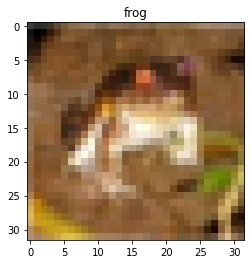

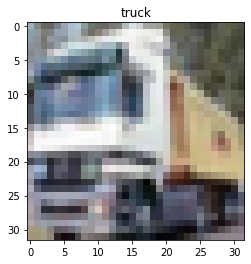

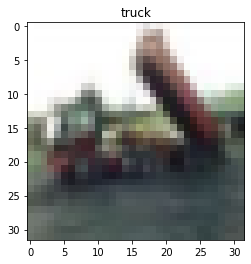

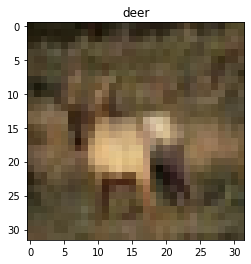

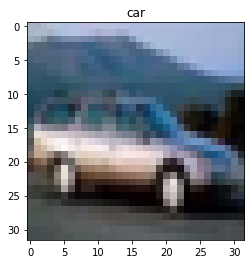

In [ ]:
num_images = 5

def plotImage(img, label):
  # denormalizes and reshapes the images, and then plots them
  img = img/2 + 0.5   #denormalize
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.title(classes[label])
  plt.show()


for i in range(num_images):
  img, label = train_set[i]
  plotImage(img, label)

# ResNet18

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Loading ResNet18.

In [ ]:
resnet18 = models.resnet18(pretrained=False, progress = True)
resnet18=resnet18.to(device)

Parameters:

In [ ]:
batch_size = 512
num_epochs = 50

val_batch_size = 1000

# SGD Parameters
lr = 5e-2
momentum = 0.9
weight_decay = 5e-4

Loss function, optimizer and schedular.

In [ ]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=lr, momentum = momentum, weight_decay = weight_decay) # can I change this? @jayesh
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100) # what this does @jayesh

#### Training the network

In [ ]:
# initializing the accuracy lists
train_accuracy = []
val_accuracy = []
epochs=[] # simply contains [i for in in range(num_epochs)]

max_validation = 0 # stores maximum validation accuracy
max_epoch=0 # stores epoch corresponding to max accuracy

In [ ]:
def forward(loader, model, device, loss_func, optimizer):
  """
    this function performs a forward pass for the given model (neural network).
    loader : train_loader
    model : resnet18
    device : cpu or cuda:0
    loss_func : torch.nn.CrossEntropyLoss()
    optimizer : torch.optim.SGD(resnet18.parameters(), lr=lr, momentum = momentum, weight_decay = weight_decay)
  """
  for imgs, labels in loader:
    if device is not None:
      imgs, labels = imgs.to(device), labels.to(device)

    outputs = model(imgs)

    loss = loss_func( outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss

In [ ]:
def getAccuracy(loader, model, device):
  """
    this function calculates accuracy for training or validation data.
    loader : train_loader/val_loader
    model : resnet18
    device : cpu or cuda:0
  """
  total = 0
  correct = 0
  for imgs, labels in loader:
    if device is not None:
      imgs,labels=imgs.to(device),labels.to(device)
    outputs = model(imgs) 
    _, predicted = torch.max(outputs, dim=1) 
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
  accuracy = correct/total

  return accuracy


In [ ]:
for i in range(1, num_epochs+1):

  loss = forward(train_loader, resnet18, device, loss_func, optimizer)

  with torch.no_grad():
    curr_val_acc = getAccuracy(val_loader, resnet18, device)
    val_accuracy.append(curr_val_acc)

    curr_train_acc = getAccuracy(train_loader, resnet18, device)
    train_accuracy.append(curr_train_acc)
    
    if curr_val_acc > max_validation:
      max_validation = curr_val_acc
      max_epoch=i
      torch.save(resnet18,'./scratch.pt' )
  epochs.append(i)
  if i%1==0: #can change this if we want to print epoch accuracies less often
    print("Epoch: %d, Loss: %f" % (i, float(loss)))
    print("Train Accuracy: ", curr_train_acc)
    print("Validation Accuracy: ", curr_val_acc)
  
  scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1, Loss: 1.264259
Train Accuracy:  0.53018
Validation Accuracy:  0.5097
Epoch: 2, Loss: 1.218511
Train Accuracy:  0.64614
Validation Accuracy:  0.5985
Epoch: 3, Loss: 0.959032
Train Accuracy:  0.7185
Validation Accuracy:  0.6429
Epoch: 4, Loss: 0.728610
Train Accuracy:  0.75776
Validation Accuracy:  0.6578
Epoch: 5, Loss: 0.651126
Train Accuracy:  0.80684
Validation Accuracy:  0.6818
Epoch: 6, Loss: 0.725121
Train Accuracy:  0.8402
Validation Accuracy:  0.6862
Epoch: 7, Loss: 0.455695
Train Accuracy:  0.886
Validation Accuracy:  0.7018
Epoch: 8, Loss: 0.407243
Train Accuracy:  0.8852
Validation Accuracy:  0.6971
Epoch: 9, Loss: 0.385454
Train Accuracy:  0.92204
Validation Accuracy:  0.7042
Epoch: 10, Loss: 0.319201
Train Accuracy:  0.93278
Validation Accuracy:  0.6998
Epoch: 11, Loss: 0.290664
Train Accuracy:  0.94654
Validation Accuracy:  0.7096
Epoch: 12, Loss: 0.236316
Train Accuracy:  0.94786
Validation Accuracy:  0.7006
Epoch: 13, Loss: 0.211176
Train Accuracy:  0.95728
Val

In [ ]:
print('The Maximum validation accuracy achieved is: ', max_validation, ' at ', max_epoch, ' epoch.')


The Maximum validation accuracy achieved is:  0.7554  at  49  epoch.


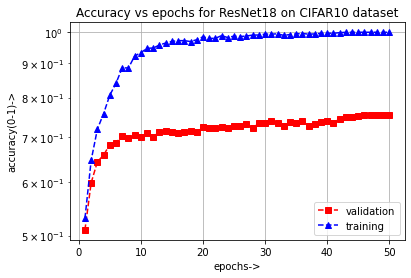

In [ ]:
plt.plot(epochs, val_accuracy, 'rs--', label = 'validation')
plt.plot(epochs, train_accuracy, 'b^--', label = 'training')
plt.yscale('log')
plt.xlabel('epochs->')
plt.ylabel('accuracy(0-1)->')
plt.title('Accuracy vs epochs for ResNet18 on CIFAR10 dataset')
plt.legend()
plt.grid(axis = 'both')
plt.show()